 # Convert Detectron2 Models to OpenVINO™

[Detectron2](https://github.com/facebookresearch/detectron2) is Facebook AI Research's library that provides state-of-the-art detection and segmentation algorithms. It is the successor of [Detectron](https://github.com/facebookresearch/Detectron/) and [maskrcnn-benchmark](https://github.com/facebookresearch/maskrcnn-benchmark/). It supports a number of computer vision research projects and production applications. 

In this tutorial we consider how to convert and run Detectron2 models using OpenVINO™. We will use `Faster R-CNN FPN x1` model and `Mask R-CNN FPN x3` pretrained on [COCO](https://cocodataset.org/#home) dataset as examples for object detection and instance segmentation respectively.


#### Table of contents:

- [Prerequisites](#Prerequisites)
    - [Define helpers for PyTorch model initialization and conversion](#Define-helpers-for-PyTorch-model-initialization-and-conversion)
    - [Prepare input data](#Prepare-input-data)
- [Object Detection](#Object-Detection)
    - [Download PyTorch Detection model](#Download-PyTorch-Detection-model)
    - [Convert Detection Model to OpenVINO Intermediate Representation](#Convert-Detection-Model-to-OpenVINO-Intermediate-Representation)
    - [Select inference device](#Select-inference-device)
    - [Run Detection model inference](#Run-Detection-model-inference)
- [Instance Segmentation](#Instance-Segmentation)
    - [Download Instance Segmentation PyTorch model](#Download-Instance-Segmentation-PyTorch-model)
    - [Convert Instance Segmentation Model to OpenVINO Intermediate Representation](#Convert-Instance-Segmentation-Model-to-OpenVINO-Intermediate-Representation)
    - [Select inference device](#Select-inference-device)
    - [Run Instance Segmentation model inference](#Run-Instance-Segmentation-model-inference)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/detectron2-to-openvino/detectron2-to-openvino.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

Install required packages for running model

In [1]:
import os
import requests
from pathlib import Path
import platform


os.environ["GIT_CLONE_PROTECTION_ACTIVE"] = "false"

if not Path("notebook_utils.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
    )
    with open("notebook_utils.py", "w") as f:
        f.write(r.text)

if not Path("pip_helper.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/pip_helper.py",
    )
    open("pip_helper.py", "w").write(r.text)

from pip_helper import pip_install

if platform.system() == "Darwin":
    pip_install("numpy<2.0.0")
pip_install("torch", "torchvision", "opencv-python", "wheel", "--extra-index-url", "https://download.pytorch.org/whl/cpu")
pip_install("git+https://github.com/facebookresearch/detectron2.git", "--extra-index-url", "https://download.pytorch.org/whl/cpu")
pip_install("openvino>=2023.1.0")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


24692

### Define helpers for PyTorch model initialization and conversion
[back to top ⬆️](#Table-of-contents:)

Detectron2 provides universal and configurable API for working with models, it means that all steps required for model creation, conversion and inference will be common for all models, that is why it is enough to define helper functions once, then reuse them for different models.
For obtaining models we will use [Detectron2 Model Zoo](https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md) API. `detecton_zoo.get` function allow to download and instantiate model based on its config file. Configuration file is playing key role in interaction with models in Detectron2 project and describes model architecture and training and validation processes. `detectron_zoo.get_config` function can be used for finding and reading model config.

In [2]:
import detectron2.model_zoo as detectron_zoo


def get_model_and_config(model_name: str):
    """
    Helper function for downloading PyTorch model and its configuration from Detectron2 Model Zoo

    Parameters:
      model_name (str): model_id from Detectron2 Model Zoo
    Returns:
      model (torch.nn.Module): Pretrained model instance
      cfg (Config): Configuration for model
    """
    cfg = detectron_zoo.get_config(model_name + ".yaml", trained=True)
    model = detectron_zoo.get(model_name + ".yaml", trained=True)
    return model, cfg

Detectron2 library is based on PyTorch. Starting from 2023.0 release OpenVINO supports PyTorch models conversion directly via Model Conversion API. `ov.convert_model` function can be used for converting PyTorch model to OpenVINO Model object instance, that ready to use for loading on device and then running inference or can be saved on disk for next deployment using `ov.save_model` function.

Detectron2 models use custom complex data structures inside that brings some difficulties for exporting models in different formats and frameworks including OpenVINO. For avoid these issues, `detectron2.export.TracingAdapter` provided as part of Detectron2 deployment API. `TracingAdapter` is a model wrapper class that simplify model's structure making it more export-friendly.

In [3]:
from detectron2.modeling import GeneralizedRCNN
from detectron2.export import TracingAdapter
import torch
import openvino as ov
import warnings
from typing import List, Dict


def convert_detectron2_model(model: torch.nn.Module, sample_input: List[Dict[str, torch.Tensor]]):
    """
    Function for converting Detectron2 models, creates TracingAdapter for making model tracing-friendly,
    prepares inputs and converts model to OpenVINO Model

    Parameters:
      model (torch.nn.Module): Model object for conversion
      sample_input (List[Dict[str, torch.Tensor]]): sample input for tracing
    Returns:
      ov_model (ov.Model): OpenVINO Model
    """
    # prepare input for tracing adapter
    tracing_input = [{"image": sample_input[0]["image"]}]

    # override model forward and disable postprocessing if required
    if isinstance(model, GeneralizedRCNN):

        def inference(model, inputs):
            # use do_postprocess=False so it returns ROI mask
            inst = model.inference(inputs, do_postprocess=False)[0]
            return [{"instances": inst}]

    else:
        inference = None  # assume that we just call the model directly

    # create traceable model
    traceable_model = TracingAdapter(model, tracing_input, inference)
    warnings.filterwarnings("ignore")
    # convert PyTorch model to OpenVINO model
    ov_model = ov.convert_model(traceable_model, example_input=sample_input[0]["image"])
    return ov_model

### Prepare input data
[back to top ⬆️](#Table-of-contents:)

For running model conversion and inference we need to provide example input. The cells below download sample image and apply preprocessing steps based on model specific transformations defined in model config.

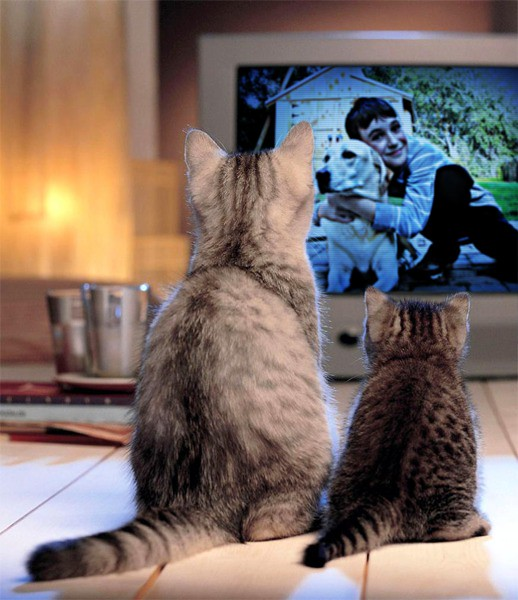

In [4]:
import requests
from pathlib import Path
from PIL import Image

MODEL_DIR = Path("model")
DATA_DIR = Path("data")

MODEL_DIR.mkdir(exist_ok=True)
DATA_DIR.mkdir(exist_ok=True)

input_image_url = "https://farm9.staticflickr.com/8040/8017130856_1b46b5f5fc_z.jpg"

image_file = DATA_DIR / "example_image.jpg"

if not image_file.exists():
    image = Image.open(requests.get(input_image_url, stream=True).raw)
    image.save(image_file)
else:
    image = Image.open(image_file)

image

In [5]:
import detectron2.data.transforms as T
from detectron2.data import detection_utils
import torch


def get_sample_inputs(image_path, cfg):
    # get a sample data
    original_image = detection_utils.read_image(image_path, format=cfg.INPUT.FORMAT)
    # Do same preprocessing as DefaultPredictor
    aug = T.ResizeShortestEdge([cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST)
    height, width = original_image.shape[:2]
    image = aug.get_transform(original_image).apply_image(original_image)
    image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))

    inputs = {"image": image, "height": height, "width": width}

    # Sample ready
    sample_inputs = [inputs]
    return sample_inputs

Now, when all components required for model conversion are prepared, we can consider how to use them on specific examples.

## Object Detection
[back to top ⬆️](#Table-of-contents:)


### Download PyTorch Detection model
[back to top ⬆️](#Table-of-contents:)

Download faster_rcnn_R_50_FPN_1x from Detectron Model Zoo.

In [6]:
model_name = "COCO-Detection/faster_rcnn_R_50_FPN_1x"
model, cfg = get_model_and_config(model_name)
sample_input = get_sample_inputs(image_file, cfg)

### Convert Detection Model to OpenVINO Intermediate Representation
[back to top ⬆️](#Table-of-contents:)

Convert model using `convert_detectron2_model` function and `sample_input` prepared above. After conversion, model saved on disk using `ov.save_model` function and can be found in `model` directory.

In [7]:
model_xml_path = MODEL_DIR / (model_name.split("/")[-1] + ".xml")
if not model_xml_path.exists():
    ov_model = convert_detectron2_model(model, sample_input)
    ov.save_model(ov_model, MODEL_DIR / (model_name.split("/")[-1] + ".xml"))
else:
    ov_model = model_xml_path

### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [8]:
from notebook_utils import device_widget

core = ov.Core()

device = device_widget()

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

### Run Detection model inference
[back to top ⬆️](#Table-of-contents:)

Load our converted model on selected device and run inference on sample input.

In [9]:
compiled_model = core.compile_model(ov_model, device.value)

In [10]:
results = compiled_model(sample_input[0]["image"])

Tracing adapter simplifies model input and output format. After conversion, model has multiple outputs in following format:
1. Predicted boxes is floating-point tensor in format [`N`, 4], where N is number of detected boxes.
2. Predicted classes is integer tensor in format [`N`], where N is number of predicted objects that defines which label each object belongs. The values range of predicted classes tensor is [0, `num_labels`], where `num_labels` is number of classes supported of model (in our case 80).
3. Predicted scores is floating-point tensor in format [`N`], where `N` is number of predicted objects that defines confidence of each prediction.
4. Input image size is integer tensor with values [`H`, `W`], where `H` is height of input data and `W` is width of input data, used for rescaling predictions on postprocessing step.

For reusing Detectron2 API for postprocessing and visualization, we provide helpers for wrapping output in original Detectron2 format.

In [11]:
from detectron2.structures import Instances, Boxes
from detectron2.modeling.postprocessing import detector_postprocess
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog
import numpy as np


def postprocess_detection_result(outputs: Dict, orig_height: int, orig_width: int, conf_threshold: float = 0.0):
    """
    Helper function for postprocessing prediction results

    Parameters:
      outputs (Dict): OpenVINO model output dictionary
      orig_height (int): original image height before preprocessing
      orig_width (int): original image width before preprocessing
      conf_threshold (float, optional, defaults 0.0): confidence threshold for valid prediction
    Returns:
      prediction_result (instances): postprocessed predicted instances
    """
    boxes = outputs[0]
    classes = outputs[1]
    has_mask = len(outputs) >= 5
    masks = None if not has_mask else outputs[2]
    scores = outputs[2 if not has_mask else 3]
    model_input_size = (
        int(outputs[3 if not has_mask else 4][0]),
        int(outputs[3 if not has_mask else 4][1]),
    )
    filtered_detections = scores >= conf_threshold
    boxes = Boxes(boxes[filtered_detections])
    scores = scores[filtered_detections]
    classes = classes[filtered_detections]
    out_dict = {"pred_boxes": boxes, "scores": scores, "pred_classes": classes}
    if masks is not None:
        masks = masks[filtered_detections]
        out_dict["pred_masks"] = torch.from_numpy(masks)
    instances = Instances(model_input_size, **out_dict)
    return detector_postprocess(instances, orig_height, orig_width)


def draw_instance_prediction(img: np.ndarray, results: Instances, cfg: "Config"):
    """
    Helper function for visualization prediction results

    Parameters:
      img (np.ndarray): original image for drawing predictions
      results (instances): model predictions
      cfg (Config): model configuration
    Returns:
       img_with_res: image with results
    """
    metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])
    visualizer = Visualizer(img, metadata, instance_mode=ColorMode.IMAGE)
    img_with_res = visualizer.draw_instance_predictions(results)
    return img_with_res

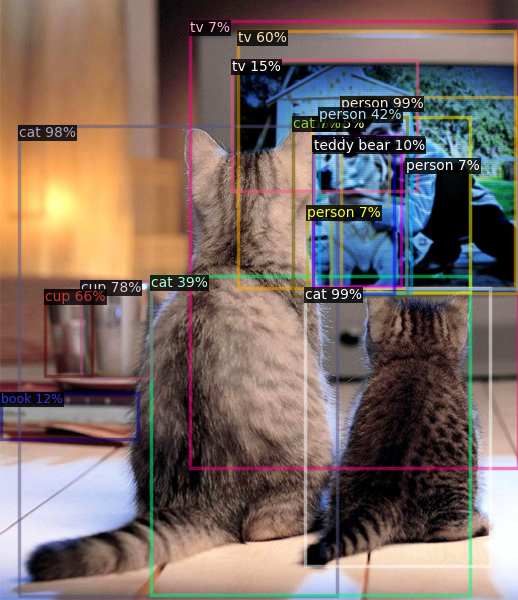

In [12]:
results = postprocess_detection_result(results, sample_input[0]["height"], sample_input[0]["width"], conf_threshold=0.05)
img_with_res = draw_instance_prediction(np.array(image), results, cfg)
Image.fromarray(img_with_res.get_image())

## Instance Segmentation
[back to top ⬆️](#Table-of-contents:)

As it was discussed above, Detectron2 provides generic approach for working with models for different use cases. The steps that required to convert and run models pretrained for Instance Segmentation use case will be very similar to Object Detection. 

### Download Instance Segmentation PyTorch model
[back to top ⬆️](#Table-of-contents:)


In [13]:
model_name = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x"
model, cfg = get_model_and_config(model_name)
sample_input = get_sample_inputs(image_file, cfg)

model_final_a3ec72.pkl: 254MB [00:20, 12.3MB/s]                                                                                                                                                                                                                                       


### Convert Instance Segmentation Model to OpenVINO Intermediate Representation
[back to top ⬆️](#Table-of-contents:)


In [14]:
model_xml_path = MODEL_DIR / (model_name.split("/")[-1] + ".xml")

if not model_xml_path.exists():
    ov_model = convert_detectron2_model(model, sample_input)
    ov.save_model(ov_model, MODEL_DIR / (model_name.split("/")[-1] + ".xml"))
else:
    ov_model = model_xml_path

### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [15]:
device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

### Run Instance Segmentation model inference
[back to top ⬆️](#Table-of-contents:)

In comparison with Object Detection, Instance Segmentation models have additional output that represents instance masks for each object. Our postprocessing function handle this difference.

In [16]:
compiled_model = core.compile_model(ov_model, device.value)

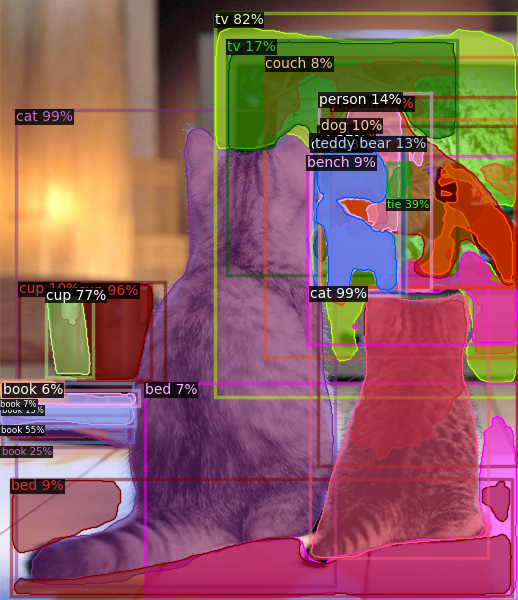

In [17]:
results = compiled_model(sample_input[0]["image"])
results = postprocess_detection_result(results, sample_input[0]["height"], sample_input[0]["width"], conf_threshold=0.05)
img_with_res = draw_instance_prediction(np.array(image), results, cfg)
Image.fromarray(img_with_res.get_image())